# Modelling based on train and augmented train data

## Overview

In this notebook we focus on create more date from the given test dataset by augmenting blood glucose level predictions. We will then use the augmented data to additionally train the model and predict the test data.


## Data Augmentation

Data augmentation is a technique used to increase the size of the training dataset based on existing data or newly created synthetic data from existing data. In this case, we will use the lag features given in the test data to create more input data for the model.

For each imputed row in the test set we can create a new row by shifting the lag features by one column. This will create a new row with the same target value but with different input features. We can then use this new data to train the model.

 

In [2]:
from datetime import datetime

from src.features.helpers.extractors import extract_patient_data
import os
import pandas as pd

df_test = pd.read_csv(os.path.join('..', '..', '..', 'data', 'raw', 'test.csv'))
extracted_data = extract_patient_data(df_test, 'p24')
extracted_data


,p_num,time,bg,insulin,carbs,hr,steps,cals,activity
2020-01-02 10:40:00,p24,10:40:00,8.7,0.0708,NaN,79.1,0.0,4.39,NaN
2020-01-02 10:45:00,p24,10:45:00,8.2,0.0708,NaN,84.1,225.0,15.94,NaN
2020-01-02 10:50:00,p24,10:50:00,8.3,0.0708,NaN,104.3,41.0,12.11,NaN
2020-01-02 10:55:00,p24,10:55:00,8.8,0.0708,NaN,85.0,53.0,6.97,NaN
2020-01-02 11:00:00,p24,11:00:00,8.9,0.0708,NaN,92.2,145.0,13.20,NaN
...,...,...,...,...,...,...,...,...,...
2020-11-29 02:50:00,p24,02:50:00,6.4,0.0771,NaN,72.7,0.0,4.31,NaN
2020-11-29 02:55:00,p24,02:55:00,6.4,0.0000,NaN,71.8,NaN,4.15,NaN
2020-11-29 03:00:00,p24,03:00:00,6.4,0.0000,NaN,76.2,0.0,4.23,NaN
2020-11-29 03:05:00,p24,03:05:00,6.5,0.0327,NaN,70.5,NaN,4.15,NaN


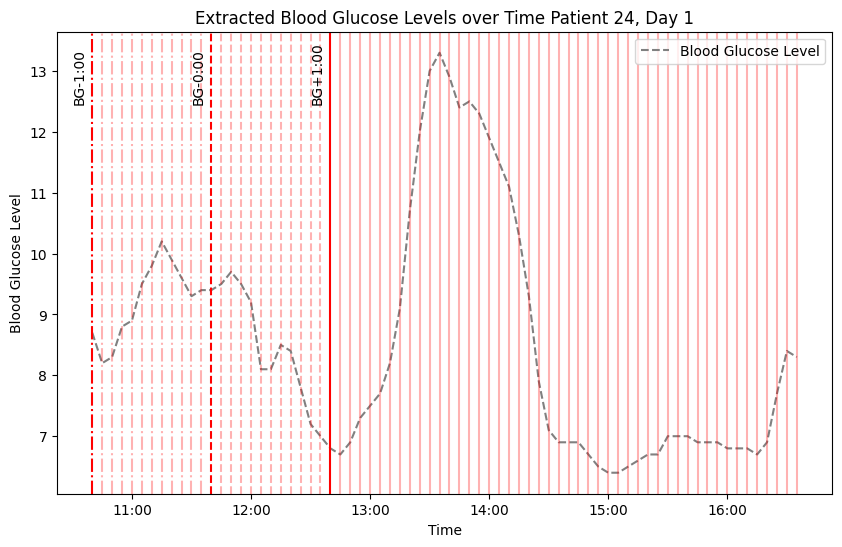

In [3]:
# plot the extracted data for the first day
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# show only data from the first day
extracted_data = extracted_data[extracted_data.index < datetime(2020, 1, 3)]
plt.figure(figsize=(10, 6))

plt.plot(extracted_data.index, extracted_data['bg'], linestyle='--', color='grey', label='Blood Glucose Level')
plt.xlabel('Time')
plt.ylabel('Blood Glucose Level')
plt.title('Extracted Blood Glucose Levels over Time Patient 24, Day 1')

date_format = mdates.DateFormatter("%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

# Vertical line at 18:00 with label 'BG+1h'
plt.axvline(x=datetime(2020, 1, 2, 10, 40), color='r', linestyle='-.')
plt.text(datetime(2020, 1, 2, 10, 30), 12.5, 'BG-1:00', rotation=90)

start_date = datetime(2020, 1, 2, 10, 45)
for i in range(11):
    plt.axvline(x=start_date + pd.Timedelta(minutes=5 * i), color='r', linestyle='-.', alpha=0.3)

plt.axvline(x=datetime(2020, 1, 2, 11, 40), color='r', linestyle='--')
plt.text(datetime(2020, 1, 2, 11, 30), 12.5, 'BG-0:00', rotation=90)

start_date = datetime(2020, 1, 2, 11, 45)
for i in range(11):
    plt.axvline(x=start_date + pd.Timedelta(minutes=5 * i), color='r', linestyle='--', alpha=0.3)

plt.axvline(x=datetime(2020, 1, 2, 12, 40), color='r', linestyle='-')
plt.text(datetime(2020, 1, 2, 12, 30), 12.5, 'BG+1:00', rotation=90)

start_date = datetime(2020, 1, 2, 12, 45)

for i in range(47):
    plt.axvline(x=start_date + pd.Timedelta(minutes=5 * i), color='r', linestyle='-', alpha=0.3)

plt.legend()
plt.show()

With this method we can create more data from the existing test dataset. Depending on the number of lag features we use more or less data can be created.

* For 1h lag: 47 new rows for each row in the test data (174.941 rows in total)
* For 2h lag: 35 new rows for each row in the test data (131,320 rows in total)
* For 3h lag: 23 new rows for each row in the test data (87.897 rows in total)
* For 4h lag: 11 new rows for each row in the test data (44711 rows in total)
* For 4:55h lag: 1 new rows for each row in the test data (3646 rows in total)


## Preprocessing and Standardization pipelines

We have created `preprocessing pipeline` based in the transformers in the previous section. The following steps have been implemented:

* `DateTimeTransformer`: Extracts the time from the time column and creates circular features for the hour and minute
* `DropColumnsTransformer`: Drops all columns for parameters `activity` and `carbs`
* `FillPropertiesNaNsTransformer`: Interpolate (limit 3), forwards and backwards fill (limit 1) and median for the remaining columns for `bg`, `insulin`, `hr`, `steps`
* `DropOutliersTransformer`: Find an rewrite outliers for `insulin`
* `ExtractFeaturesTransformer`: Extracts all specified columns, here:
    * hour_sin, hour_cos
    * bg-0:00 - bg-2:00
    * insulin-0:00 - insulin-2:00
    * cals-0:00 - cals-2:00
    * hr-0:00 - hr-2:00
    * steps-0:00 - steps-2:00
    * p_num
    * bg+1:00 (target)


``` python
    preprocessing_pipeline = Pipeline(steps=[
        ('date_time', DateTimeHourTransformer(time_column='time', result_column='hour', type='sin_cos', drop_time_column=True)),
        ('drop_parameter_cols', DropColumnsTransformer(starts_with=['activity', 'carbs'])),
        ('drop_others', DropColumnsTransformer(columns_to_delete=['time'])),
        ('fill_properties_nan_bg', FillPropertyNaNsTransformer(parameter='bg', how=['interpolate', 'median'], interpolate=3, ffill=1, bfill=1, precision=1)),
        ('fill_properties_nan_insulin', FillPropertyNaNsTransformer(parameter='insulin', how=['interpolate', 'median'], interpolate=3, ffill=1, bfill=1, precision=4)),
        ('fill_properties_nan_cals', FillPropertyNaNsTransformer(parameter='cals', how=['interpolate', 'median'], interpolate=3, ffill=1, bfill=1, precision=1)),
        ('fill_properties_nan_hr', FillPropertyNaNsTransformer(parameter='hr', how=['interpolate', 'median'], interpolate=3, ffill=1, bfill=1, precision=1)),
        ('fill_properties_nan_steps', FillPropertyNaNsTransformer(parameter='steps', how=['zero'], interpolate=3, ffill=1, bfill=1, precision=1)),
        ('drop_outliers', PropertyOutlierTransformer(parameter='insulin', filter_function=lambda x: x < 0, fill_strategy='zero')),
        ('extract_features', ExtractColumnsTransformer(columns_to_extract=columns_to_extract)),
    ])
```

The `standardization pipeline` contains of:

* `GetDummiesTransformer`: One hot encodes the `p_num` column
* `StandardScaler`: Standardizes the data (excluding the target column)

``` python
    standardization_pipeline = Pipeline(steps=[
      ('get_dummies', GetDummiesTransformer(columns=['hour', 'p_num'])),
        ('standard_scaler', StandardScalerTransformer(columns=columns_to_extract[3:-1]))
    ])
```

In [4]:
from src.features.helpers.load_data import load_data
from src.models.model.pipelines_2h import pipeline

train_data, augmented_data, test_data = load_data('2_00h')

all_train_data_transformed = pipeline.fit_transform(pd.concat([train_data, augmented_data]))

X_train, y_train = all_train_data_transformed.iloc[len(train_data):].drop(columns=['bg+1:00']), all_train_data_transformed.iloc[len(train_data):]['bg+1:00']
X_augmented, y_augmented = all_train_data_transformed.iloc[:len(train_data)].drop(columns=['bg+1:00']), all_train_data_transformed.iloc[:len(train_data)]['bg+1:00']

all_train_data_transformed.head()

,hour_sin,hour_cos,bg-2:00,bg-1:55,bg-1:50,bg-1:45,bg-1:40,bg-1:35,bg-1:30,bg-1:25,...,p_num_p10,p_num_p11,p_num_p12,p_num_p15,p_num_p16,p_num_p18,p_num_p19,p_num_p21,p_num_p22,p_num_p24
id,,,,,,,,,,,,,,,,,,,,,
p01_0,0.999048,-0.043619,2.815442,2.915458,3.044933,3.141255,3.176766,3.176801,3.208038,3.178700,...,0,0,0,0,0,0,0,0,0,0
p01_1,0.994056,-0.108867,3.138183,3.173915,3.174163,3.205851,3.176766,3.112147,3.078782,3.016990,...,0,0,0,0,0,0,0,0,0,0
p01_2,0.984808,-0.173648,3.202732,3.173915,3.109548,3.076659,3.015126,2.918186,2.852584,2.887622,...,0,0,0,0,0,0,0,0,0,0
p01_3,0.971342,-0.237686,3.073635,3.012379,2.915704,2.850574,2.885814,2.885859,2.917212,2.887622,...,0,0,0,0,0,0,0,0,0,0
p01_4,0.953717,-0.300706,2.847716,2.883151,2.883396,2.915169,2.885814,2.885859,2.852584,2.725913,...,0,0,0,0,0,0,0,0,0,0


## Lazy Predict

To get some fast insights about the results of different regression models we can use the `LazyPredict` library. This library trains a set of regression models on the data and return the results. This can be used to get a quick overview of the performance of different models. For our usecase we wrote wrapper araound LazyPredict to have more control over the models applied. 

In [5]:
from src.features.helpers.LazyPredict import get_lazy_regressor
from sklearn.model_selection import train_test_split

X_augmented_train, X_augmented_test, y_augmented_train, y_augmented_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

X_train_all = pd.concat([X_train, X_augmented_train], axis=0)
y_train_all = pd.concat([y_train, y_augmented_train], axis=0)

#lazy_predict_regressor = get_lazy_regressor(exclude=['SVN'])
#models, predictions = lazy_predict_regressor.fit(X_train=X_train_all, y_train=y_train_all, X_test=X_augmented_test, y_test=y_augmented_test)
#models

## Model Selection

Based on the results from the `LazyPredict` library we can select the best performing models from each category, fine tune them and use them in a `StackingRegressor` for the final prediction. 

In this case we will use:
 
* `HistGradientBoostingRegressor`
* `LassoLarsICRegressor`
* `KNNRegressor`
* `XGBRegressor`


## Feature Selection

We can use the `SelectKBest` transformer from `sklearn` to select the best features for the model. This can be used to reduce the number of features and improve the performance of the model.


In [6]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=10)
selector.fit(X_train_all, y_train_all)

SelectKBest(score_func=<function f_regression at 0x10b581300>)

In [8]:
selected_features = X_train_all.columns[selector.get_support()]
selected_features

Index(['bg-0:45', 'bg-0:40', 'bg-0:35', 'bg-0:30', 'bg-0:25', 'bg-0:20',
       'bg-0:15', 'bg-0:10', 'bg-0:05', 'bg-0:00'],
      dtype='object')

## Hyperparameter Tuning

## Ensemble model prediction

## Kaggle Submission